In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

In [ ]:
import json
import pandas as pd
import time
import networkx as nx
from torch_geometric.utils import from_networkx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCN, GAT, GraphSAGE
from torch.utils.data import Dataset, DataLoader

In [ ]:
nx_graph = nx.read_gml('graph_with_features.gml')
G = from_networkx(nx_graph, group_node_attrs=['out_degree', 'in_degree', 'category_multi_hot', 'article_embed'])

path_data = pd.read_csv('data_by_index.tsv', sep='\t', header=None)

In [ ]:
def get_evaluation_metrics(model, device, dataloader, dataset_size):
    model.eval()
    avg_loss = 0
    num_correct = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # get data
            inputs, labels = data['indices'].to(device), data['label'].to(device)
            outputs = model(inputs)
            # get loss
            loss = F.nll_loss(outputs, labels)
            avg_loss += loss.item()
            # get accuracy
            pred = outputs.argmax(dim=1)
            correct = (pred == labels).sum()
            num_correct += correct
    acc = int(num_correct) / dataset_size
    avg_loss /= dataset_size
    return acc, avg_loss

In [ ]:
class CustomPathDataset(Dataset):
    def __init__(self, path_data):
        self.x = path_data[0].apply(json.loads)
        self.labels = path_data[1]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.LongTensor(self.x[idx])
        label = self.labels[idx]
        sample = {"indices": x, "label": label}
        return sample

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, graph, device, gnn_hidden_size=128, node_embed_size=64, lstm_hidden_size=32):
        super().__init__()
        self.graphX = graph.x.to(device)
        self.graphEdgeIndex = graph.edge_index.to(device)
        self.gnn = GCN(in_channels=self.graphX.shape[1], 
                       hidden_channels=gnn_hidden_size, 
                       num_layers=3, 
                       out_channels=node_embed_size, 
                       dropout=0.1)
        self.batch_norm = nn.BatchNorm1d(32)
        self.lstm_input_size = node_embed_size
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            batch_first=True)
        self.pred_head = nn.Linear(lstm_hidden_size, self.graphX.shape[0])

    def forward(self, indices):
        node_emb = self.gnn(self.graphX, self.graphEdgeIndex)
        node_emb_with_padding = torch.cat([node_emb, torch.zeros((1, self.lstm_input_size)).to(device)])
        paths = node_emb_with_padding[indices]
        paths = self.batch_norm(paths)
        _, (h_n, _) = self.lstm(paths)
        predictions = self.pred_head(torch.squeeze(h_n))
        return F.log_softmax(predictions, dim=1)

In [ ]:
# set up our model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(G, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # NOTE: lr=0.01

# get our dataset + splits
dataset = CustomPathDataset(path_data)
train_size = int(0.9 * len(dataset))
test_size = int(0.05 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# set up for training + validation
batch_size = 1024
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
best_acc = 0
training_losses = []
validation_losses = []
validation_accs = []
model.train()
for epoch in range(200):  # loop over the dataset multiple times
    print('Epoch:', epoch+1)
    model.train()
    epoch_loss = 0
    start_time = time.time()
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['indices'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    # validate epoch and print results
    training_losses.append(epoch_loss / train_size)
    print('Training Loss:', training_losses[-1])
    acc, valid_loss = get_evaluation_metrics(model, device, validloader, val_size)
    validation_losses.append(valid_loss)
    validation_accs.append(acc)
    if acc > best_acc:
        torch.save(model.state_dict(), "gcn_hiddenstate_weights_12_07.pth")
        best_acc = acc
    print("Validation accuracy:", acc)
    print("Validation loss:", valid_loss)
    print('Time elapsed:', time.time() - start_time)
    print()

In [ ]:
acc, test_loss = get_evaluation_metrics(model, device, testloader, test_size)
print("Test accuracy:", acc)
print("Test loss:", test_loss)

In [35]:
import matplotlib.pyplot as plt

training_losses = []
validation_losses = []
validation_accs = []

lines = []
with open('graphsage_hiddenstate_log_12_07.txt') as f:
  lines = f.readlines()

for line in lines:
  if line.startswith("Training Loss"):
    training_losses.append(float(line.split()[2]))
  elif line.startswith("Validation loss"):
    validation_losses.append(float(line.split()[2]))
  elif line.startswith("Validation accuracy"):
    validation_accs.append(float(line.split()[2]))

print(len(training_losses), len(validation_losses), len(validation_accs))

200 200 200


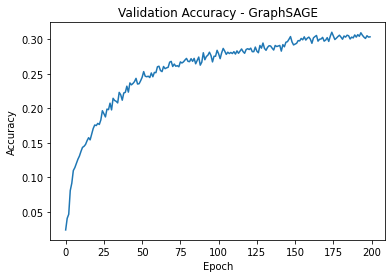

In [36]:
plt.plot(validation_accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy - GraphSAGE')
plt.savefig('validation_acc_graphsage_hiddenstate.png')

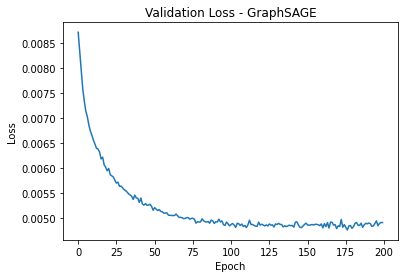

In [37]:
plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss - GraphSAGE')
plt.savefig('validation_loss_graphsage_hiddenstate.png')

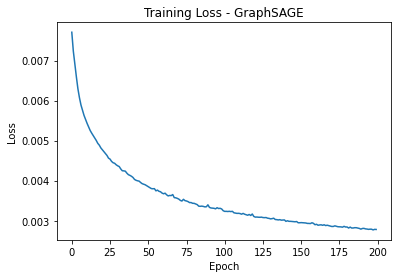

In [38]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - GraphSAGE')
plt.savefig('training_loss_graphsage_hiddenstate.png')